# Train and validate ML model for phenotypic classification of nuclei

### Use training data with DeepProfiler features from [training_data.csv.gz](../1.format_data/data/training_data.csv.gz)

### Import libraries

In [1]:
import pandas as pd
from typing import Tuple, Any, List
from sklearn.linear_model import LogisticRegression, LinearRegression
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pathlib

import seaborn as sns

### Helper functions for data loading, training, and validation

In [2]:
def get_X_y_data(load_path: pathlib.Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """generate X (features) and y (labels) dataframes from training data

    Args:
        load_path (pathlib.Path): path to training data csv

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: X, y dataframes
    """
    # read dataset into pandas dataframe
    training_data = pd.read_csv(load_path, index_col=0)

    # remove training data with ADCCM class as this class was not used for classification in original paper
    training_data = training_data[
        training_data["Mitocheck_Phenotypic_Class"] != "ADCCM"
    ]

    # all features from DeepProfiler have "efficientnet" in their column name
    morphology_features = [
        col for col in training_data.columns.tolist() if "efficientnet" in col
    ]

    # extract features
    X = training_data.loc[:, morphology_features].values

    # extract phenotypic class label
    y = training_data.loc[:, ["Mitocheck_Phenotypic_Class"]].values
    # make Y data
    y = np.ravel(y)

    # shuffle data because as it comes from MitoCheck same labels tend to be in grou
    X, y = shuffle(X, y, random_state=0)

    return X, y


def average_feature_weights(estimator_list: List) -> np.array:
    """average coefs from list of estimators

    Args:
        estimator_list (List): list of estimators from cross_validate()

    Returns:
        np.array: average coefs array
    """
    coefs = []
    for estimator in estimator_list:
        coefs.append(estimator.coef_)
    return np.mean(coefs, axis=0)

In [3]:
# load x (features) and y (labels) dataframes
load_path = pathlib.Path("../1.format_data/data/training_data.csv.gz")
X, y = get_X_y_data(load_path)

print(X.shape)
print(y.shape)

# create stratified data sets for k-fold cross validation
straified_k_folds = StratifiedKFold(n_splits=10, shuffle=False)

(4123, 1280)
(4123,)


In [4]:
# create logistic regression model with following parameters
log_reg_model = LogisticRegression(l1_ratio=0, penalty='elasticnet', solver='saga', max_iter=100, n_jobs=-1, random_state=0)

In [5]:
# cross validation with logistic regression model across stratified data sets
cv_results = cross_validate(log_reg_model, X, y, cv=straified_k_folds, n_jobs=-1, return_estimator=True)
avg_score = np.mean(cv_results['test_score'])
print(f"Average score: {avg_score}")

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklea

Average score: 0.808147229601072


/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklea

<Figure size 432x288 with 0 Axes>

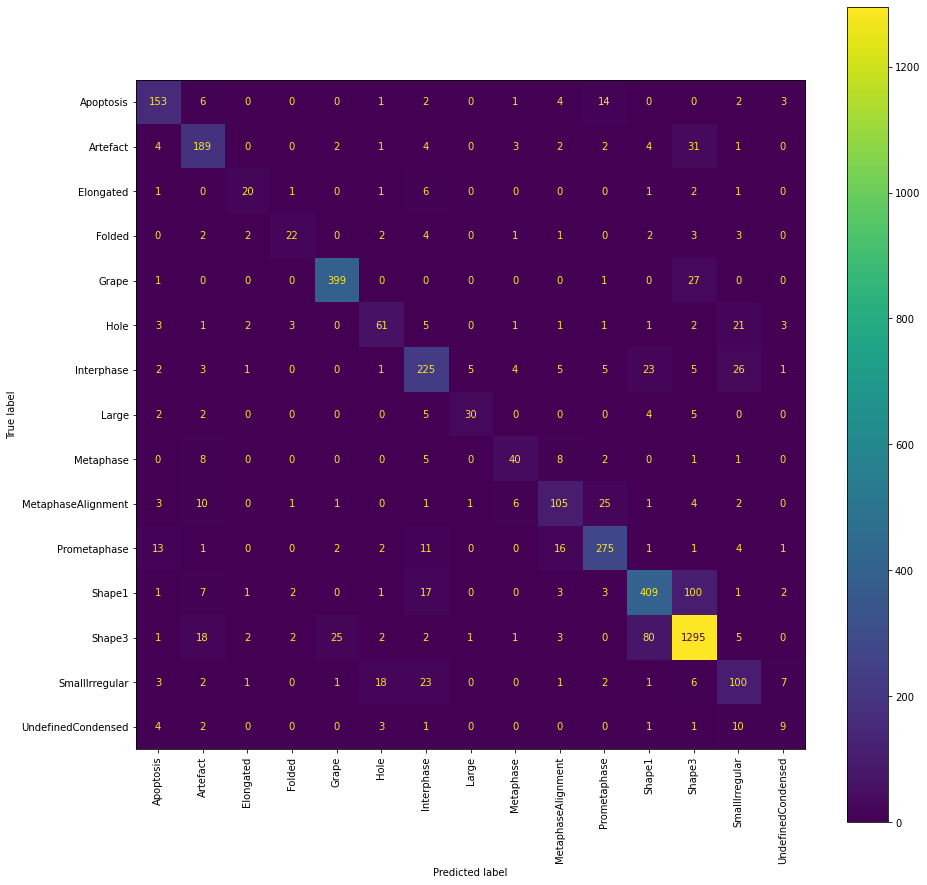

In [6]:
# create confusion matrix for logistic regression model after cross validation
y_pred = cross_val_predict(log_reg_model, X, y, cv=straified_k_folds, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)

# display confusion matrix
plt.clf()
plt.rcParams['figure.figsize'] = [15, 15]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=cv_results['estimator'][0].classes_)
disp.plot()
plt.xticks(rotation=90)
plt.show()

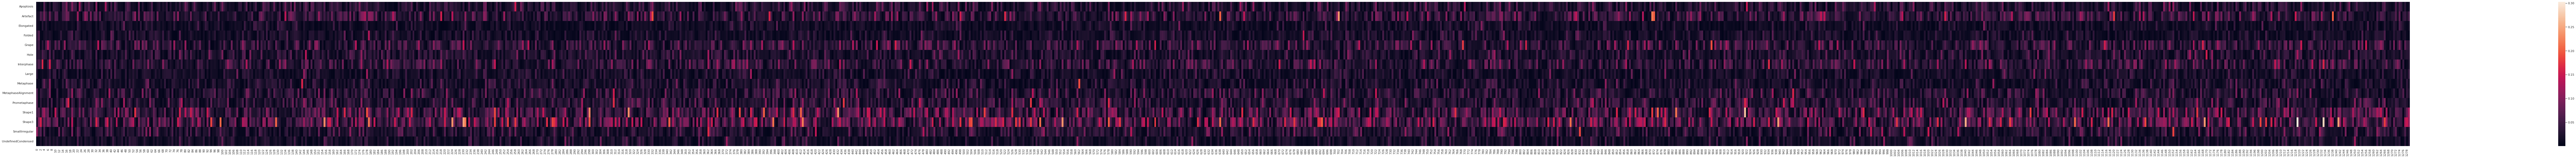

In [7]:
# find absolute value of average coefs
average_coefs = average_feature_weights(cv_results["estimator"])
average_coefs = np.abs(average_coefs)

# display heatmap of average coefs
classes = cv_results["estimator"][0].classes_
sns.set(rc={"figure.figsize": (200, 10)})
ax = sns.heatmap(average_coefs)
ax = ax.set_yticklabels(classes, rotation=0)